In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd # importing the required libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from torchsummary import summary
from PIL import Image

In [3]:
dir = "/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)" # giving the dataset path
train_dir = dir + "/train"
valid_dir = dir + "/test-valid"

In [4]:
diseases = os.listdir(train_dir)
total_plants = []
total_diseases = 0
for p in diseases:
    if p.split('___')[0] not in total_plants:
        total_plants.append(p.split('___')[0])
    if p.split('___')[1] != 'healthy':
        total_diseases += 1
print(f"Unique Plants are: \n{total_plants}") # displaying the name of unique plants

Unique Plants are: 
['Corn_(maize)', 'Cherry_(including_sour)', 'Pepper,_bell', 'Apple', 'Blueberry', 'Tomato', 'Peach', 'Potato', 'Strawberry', 'Squash', 'Soybean', 'Raspberry', 'Grape', 'Orange']


In [5]:
print("Total plants: {}".format(len(total_plants)))
print("Total diseases: {}".format(total_diseases))
print("Number of disease classes : {}".format(len(diseases))) #displaying details

Total plants: 14
Total diseases: 26
Number of disease classes : 38


In [6]:
#displaying the number of images in the directory
count = {}
for i in diseases:
    count[i] = len(os.listdir(train_dir + '/' + i))
img_count_class = pd.DataFrame(count.values(), index=count.keys(), columns=["no. of images"])
img_count_class

no. of images
Corn_(maize)___healthy                                        109
Cherry_(including_sour)___Powdery_mildew                      109
Pepper,_bell___healthy                                        109
Apple___Black_rot                                             245
Apple___Apple_scab                                            189
Blueberry___healthy                                           184
Tomato___healthy                                              109
Tomato___Septoria_leaf_spot                                   109
Peach___Bacterial_spot                                        109
Potato___Late_blight                                          109
Tomato___Leaf_Mold                                            109
Strawberry___healthy                                          109
Tomato___Spider_mites Two-spotted_spider_mite                 109
Squash___Powdery_mildew                                       109
Tomato___Target_Spot                                          109
Peach___healthy                                               109
Soybean___healthy                                             109
Potato___healthy                                              109
Cherry_(including_sour)___healthy                             109
Tomato___Early_blight                                         109
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot             90
Strawberry___Leaf_scorch                                      109
Raspberry___healthy                                           109
Tomato___Bacterial_spot                                       109
Pepper,_bell___Bacterial_spot                                 109
Tomato___Tomato_mosaic_virus                                  109
Potato___Early_blight                                         109
Grape___Black_rot                                             109
Grape___healthy                                               109
Corn_(maize)___Northern_Leaf_Blight                           109
Apple___Cedar_apple_rust                                      150
Orange___Haunglongbing_(Citrus_greening)                      109
Grape___Esca_(Black_Measles)                                  109
Apple___healthy                                               142
Corn_(maize)___Common_rust_                                   109
Tomato___Late_blight                                          109
Tomato___Tomato_Yellow_Leaf_Curl_Virus                        109
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                    109

In [7]:
#counting the number of images in dataset
train_imgs = 0
for i in count.values():
    train_imgs += i
print(f"Total images for training: {train_imgs}")

Total images for training: 4488


In [8]:
#new datasets for validation and training purpose
train_data = ImageFolder(train_dir, transform=transforms.ToTensor())
valid_data = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [9]:
# class
img, label = train_data[0]
print(img.shape, label)
print(f"class count: {len(train_data.classes)}")

torch.Size([3, 256, 256]) 0
class count: 38


In [10]:
def display(img, lbl):
    print("Label :" + train_data.classes[lbl] + "(" + str(lbl) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


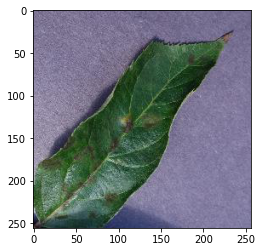

In [11]:
#showing sample data
display(*train_data[0])

In [12]:
# giving  random seed and batch size
random_seed = 7
torch.manual_seed(random_seed)
batch_size = 40

In [13]:
new_train = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
new_valid = DataLoader(valid_data, batch_size, num_workers=2, pin_memory=True)

In [14]:
#writing method for display function
def display_batch(item):
    for img, lbl in item:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img, nrow=8).permute(1, 2, 0))
        break

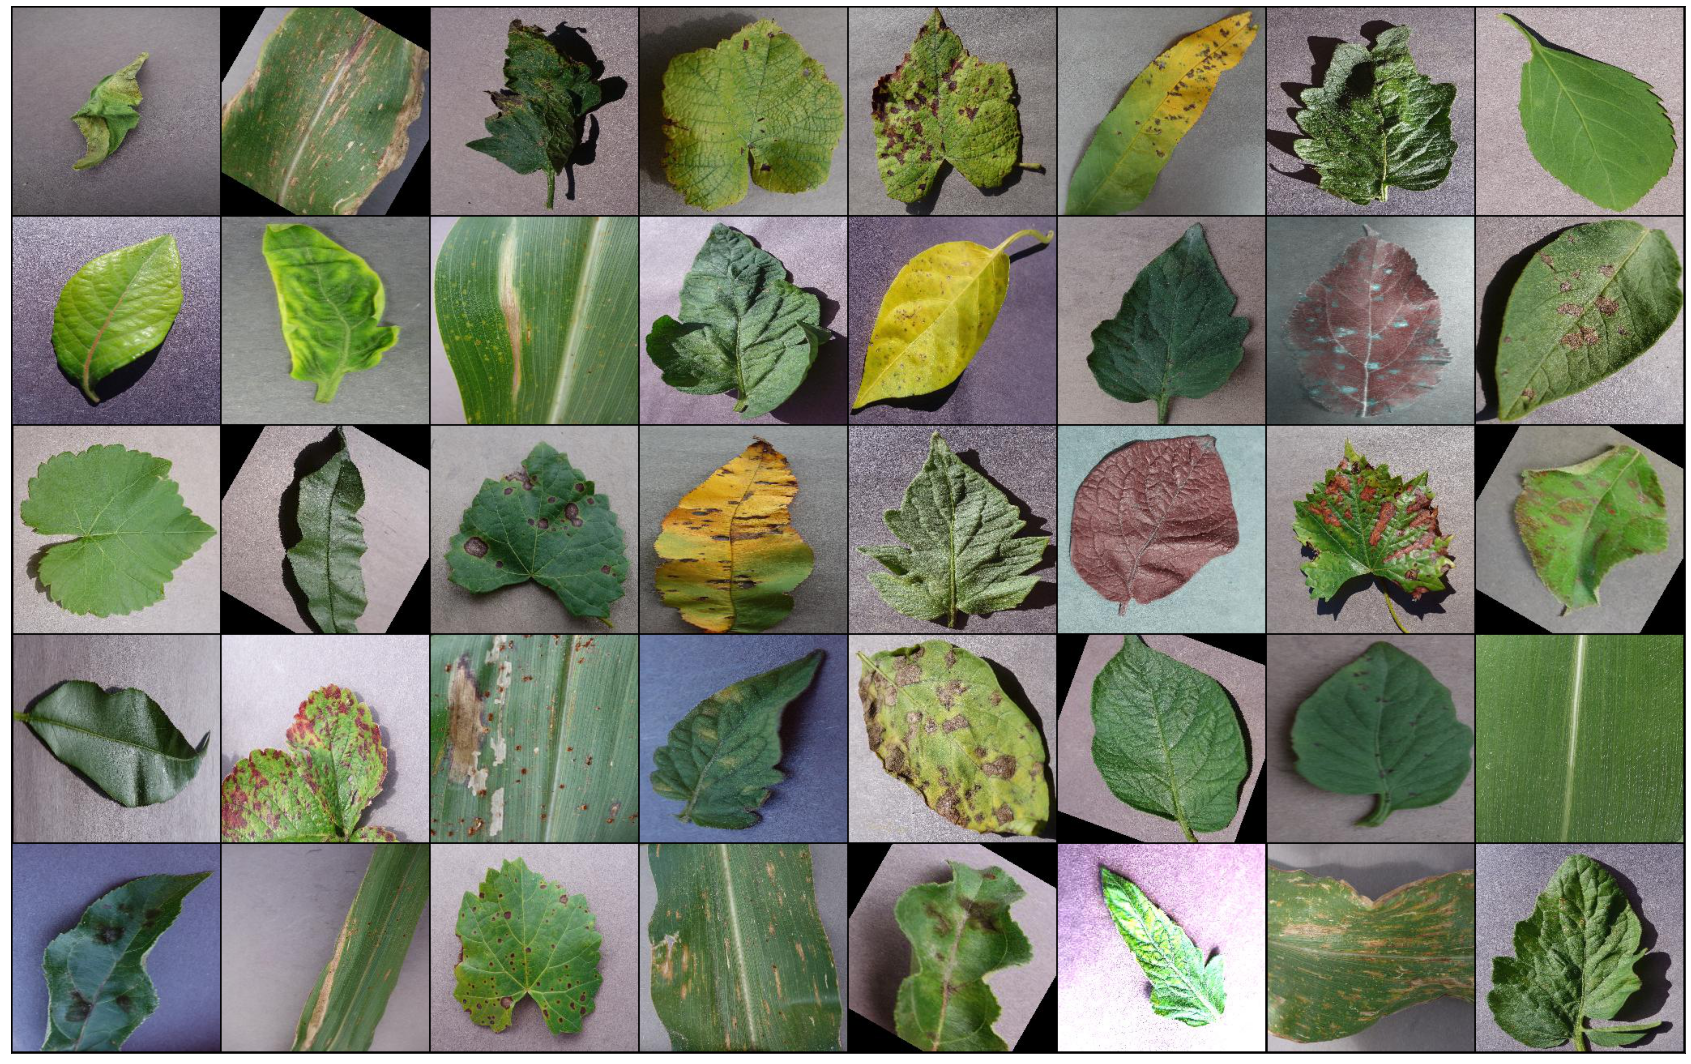

In [15]:
display_batch(new_train)  # displaying images in whole batch

In [16]:
def get_device(): # checking for cuda availability
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        return len(self.dl) 

In [17]:
#checking device type
device_name = get_device()
device_name 

device(type='cuda')

In [18]:
#moving data to gpu
new_train = DeviceLoader(new_train, device_name)
new_valid = DeviceLoader(new_valid, device_name)

In [19]:
class SimpleResidualBlock(nn.Module):
    def __init__(item):
        super().__init__()
        item.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        item.relu1 = nn.ReLU()
        item.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        item.relu2 = nn.ReLU()
        
    def forward(item, x):
        out = item.conv1(x)
        out = item.relu1(out) # applied relu for output layer
        out = item.conv2(out)
        return item.relu2(out) + x

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch): # val accuracy
        images, labels = batch
        out = self(images)                   
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)          
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs): 
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()        
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))   

In [21]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)
 
class ResNet9(ImageClassificationBase): # defining resnet 9
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) #  256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) #  512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out   

In [22]:
model = to_device(ResNet9(3, len(train_data.classes)), device_name) 
model # displaying my model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [23]:
shape = (3, 256, 256)
print(summary(model.cuda(), (shape))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
             # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [25]:
CUDA_LAUNCH_BLOCKING=1.

In [26]:
history = [evaluate(model, new_valid)] # evaluatig our model
history

[{'val_accuracy': tensor(0.0262), 'val_loss': tensor(3.6388, device='cuda:0')}]

In [27]:
epochs = 10 #epochs
max_lr = 0.01
grad_clip = 0.1
weight_decay = 0
opt_func = torch.optim.Adam  #using adam as optimizer

In [28]:
%%time
history += fit_OneCycle(epochs, max_lr, model, new_train, new_valid, weight_decay=0, grad_clip=grad_clip, opt_func=opt_func) #running epochs and checking accuracies

Epoch [0], last_lr: 0.00277, train_loss: 2.2202, val_loss: 8.1901, val_acc: 0.1159
Epoch [1], last_lr: 0.00759, train_loss: 1.6655, val_loss: 16.2944, val_acc: 0.0963
Epoch [2], last_lr: 0.01000, train_loss: 1.5351, val_loss: 6.5360, val_acc: 0.2346
Epoch [3], last_lr: 0.00950, train_loss: 0.7055, val_loss: 1.2544, val_acc: 0.7133
Epoch [4], last_lr: 0.00812, train_loss: 0.3955, val_loss: 1.5840, val_acc: 0.6200
Epoch [5], last_lr: 0.00611, train_loss: 0.3259, val_loss: 0.4179, val_acc: 0.8732
Epoch [6], last_lr: 0.00389, train_loss: 0.1176, val_loss: 0.2318, val_acc: 0.9305
Epoch [7], last_lr: 0.00188, train_loss: 0.0373, val_loss: 0.1305, val_acc: 0.9591
Epoch [8], last_lr: 0.00050, train_loss: 0.0228, val_loss: 0.1123, val_acc: 0.9677
Epoch [9], last_lr: 0.00000, train_loss: 0.0187, val_loss: 0.1122, val_acc: 0.9671
CPU times: user 12min 17s, sys: 9min 44s, total: 22min 2s
Wall time: 42min 27s


In [31]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

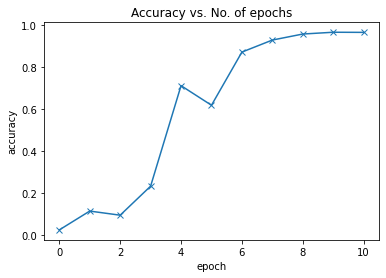

In [32]:
plot_accuracies(history)

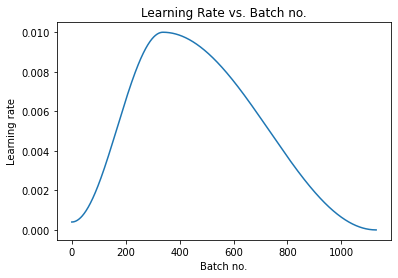

In [34]:
plot_lrs(history)

In [35]:
test_dir = dir + "/test" #importing dataset

In [36]:
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [37]:
test_images = sorted(os.listdir(test_dir + '/test'))  # printing in sorted order
test_images

['Apple__Apple_scab',
 'Apple__Cedar_apple_rust(1).jpg',
 'Apple__Cedar_apple_rust(2).jpg',
 'Apple__Cedar_apple_rust(3).jpg',
 'Apple__Cedar_apple_rust.jpg',
 'Corn_(maize)___Common_rust_(1).jpg',
 'Corn_(maize)___Common_rust_(2).jpg',
 'Corn_(maize)___Common_rust_.jpg',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [43]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device_name)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)

    return train_data.classes[preds[0].item()]

# Predicting Image 1

Label: Apple__Apple_scab , Predicted: Apple___Cedar_apple_rust


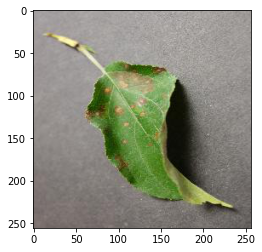

In [44]:
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model)) #checking whether it is predicted

In [49]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[0], ', Predicted:', predict_image(img, model))  #for checking prediction is correct or not

Label: Apple__Apple_scab , Predicted: Apple___Cedar_apple_rust
Label: Apple__Apple_scab , Predicted: Apple___Cedar_apple_rust
Label: Apple__Apple_scab , Predicted: Apple___Cedar_apple_rust
Label: Apple__Apple_scab , Predicted: Apple___Cedar_apple_rust
Label: Apple__Apple_scab , Predicted: Corn_(maize)___Common_rust_
Label: Apple__Apple_scab , Predicted: Corn_(maize)___Common_rust_
Label: Apple__Apple_scab , Predicted: Corn_(maize)___Common_rust_
Label: Apple__Apple_scab , Predicted: Potato___Early_blight
Label: Apple__Apple_scab , Predicted: Potato___Early_blight
Label: Apple__Apple_scab , Predicted: Soybean___healthy
Label: Apple__Apple_scab , Predicted: Potato___Early_blight
Label: Apple__Apple_scab , Predicted: Potato___Early_blight
Label: Apple__Apple_scab , Predicted: Potato___healthy
Label: Apple__Apple_scab , Predicted: Potato___healthy
Label: Apple__Apple_scab , Predicted: Tomato___Early_blight
Label: Apple__Apple_scab , Predicted: Tomato___Late_blight
Label: Apple__Apple_scab 

After hypermater tuning

In [50]:
# setting the batch size
batch_size = 32

In [51]:
new_train = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
new_valid = DataLoader(valid_data, batch_size, num_workers=2, pin_memory=True)

In [52]:
def display_batch(item): # function for displaying batch 
    for img, lbl in item:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img, nrow=8).permute(1, 2, 0))
        break

In [53]:
def get_device(): # checking for cuda availability
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        return len(self.dl) 


In [54]:
device_name = get_device()
device_name 

device(type='cuda')

In [55]:
new_train = DeviceLoader(new_train, device_name) # for improving speed moving data in to gpu
new_valid = DeviceLoader(new_valid, device_name)

In [56]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [57]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # predictions generating
        loss = F.cross_entropy(out, labels) #  loss calculation
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          # Calculating accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))   

In [58]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) #  128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

          
        
        self.conv3 = ConvBlock(128, 256, pool=True) # 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out  

In [59]:
model = to_device(ResNet9(3, len(train_data.classes)), device_name) 
model #showing our model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [60]:
shape = (3, 256, 256)
print(summary(model.cuda(), (shape))) #model symmary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [61]:

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
      
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
        
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
           
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
 
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    
    

In [62]:
CUDA_LAUNCH_BLOCKING=1. # for tracing cuda error

In [64]:
history = [evaluate(model, new_valid)] # evaluating our model
history

[{'val_accuracy': tensor(0.0276), 'val_loss': tensor(3.6395, device='cuda:0')}]

In [65]:
epochs = 10 
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4 # parameter has changed
opt_func = torch.optim.Adam

In [68]:
%%time
history += fit_OneCycle(epochs, max_lr, model, new_train, new_valid, weight_decay=0, grad_clip=grad_clip, opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 0.1070, val_loss: 2.8148, val_acc: 0.5751
Epoch [1], last_lr: 0.00759, train_loss: 0.6335, val_loss: 1.2178, val_acc: 0.6833
Epoch [2], last_lr: 0.01000, train_loss: 0.5473, val_loss: 0.9767, val_acc: 0.7434
Epoch [3], last_lr: 0.00950, train_loss: 0.3463, val_loss: 1.4953, val_acc: 0.6364
Epoch [4], last_lr: 0.00812, train_loss: 0.1842, val_loss: 1.1579, val_acc: 0.7272
Epoch [5], last_lr: 0.00611, train_loss: 0.0904, val_loss: 0.1781, val_acc: 0.9471
Epoch [6], last_lr: 0.00389, train_loss: 0.0466, val_loss: 0.1313, val_acc: 0.9597
Epoch [7], last_lr: 0.00188, train_loss: 0.0117, val_loss: 0.0899, val_acc: 0.9724
Epoch [8], last_lr: 0.00050, train_loss: 0.0068, val_loss: 0.1004, val_acc: 0.9694
Epoch [9], last_lr: 0.00000, train_loss: 0.0051, val_loss: 0.0886, val_acc: 0.9712
CPU times: user 12min 23s, sys: 9min 35s, total: 21min 58s
Wall time: 22min 31s


In [69]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

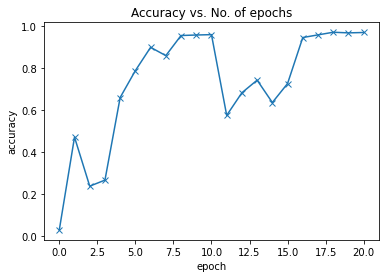

In [71]:
plot_accuracies(history)

In [ ]:
pwd

'/content'

In [76]:
PATH = './plant-disease-model.pth'   #saving the model
torch.save(model.state_dict(), PATH)

In [77]:
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)